In [3]:
from __future__ import print_function
import pandas as pd
import numpy as np
import os
import re
import json
from itertools import chain
from time import time
import math
import numpy as np
import string
import matplotlib.pyplot as plt
from nltk.tag import pos_tag
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, wordpunct_tokenize, WhitespaceTokenizer, sent_tokenize, MWETokenizer
from nltk.corpus import stopwords
from nltk.chunk import ne_chunk
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from stop_words import get_stop_words
from gensim import corpora, models, similarities, matutils
from textblob import TextBlob
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn import preprocessing
from sklearn.cluster import KMeans, DBSCAN
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import linear_model
from sklearn import ensemble
from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import pyLDAvis.gensim

/Users/flowinger/anaconda/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [6]:
df = pd.read_csv('fletcher_500k.csv')
df = df[df['author'] != '[deleted]'].dropna()
df = df.sort_values('author')

In [63]:
def lemmatize(sentence):
    lem = WordNetLemmatizer()
    lemmed = [lem.lemmatize(w.replace(',','').replace('"','')) for w in sentence.split(' ')]
    
    return " ".join(lemmed)

def translate_slang(sentence):
    slang = {'rt':'Retweet', 'dm':'direct message', 'awsm' : 'awesome', 'luv' :'love'}
    std = []
    for word in sentence.split(' '):
        if word in slang:
            word = slang[word.lower()]
            std.append(word)
        else:
            std.append(word)

    return " ".join(std)

def sentiment(sentence):
    sid = SentimentIntensityAnalyzer()
    sent = []
    for word in sentence.split(' '):
        #print(word)
        token = sent_tokenize(word)
        sentence_stats = map(lambda sentence: sid.polarity_scores(sentence), token)
        stats = {'neg': 0, 'neu': 0, 'pos': 0}
        for stat in sentence_stats:
            stats['neg'] += stat['neg']
            stats['neu'] += stat['neu']
            stats['pos'] += stat['pos']
        len_sentences_stats = len(list(sentence_stats))
        if len_sentences_stats != 0:
            stats['neg'] /= len_sentences_stats
            stats['neu'] /= len_sentences_stats
            stats['pos'] /= len_sentences_stats
        sent.append([stats['neg'],stats['neu'],stats['pos']])
    return sent

class CleanText(BaseEstimator, TransformerMixin):
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # list of stop words
        stop = set(['Heh','heh','language','know', 'wow', 'hah', 'hey','really','year', 'yeah','wtf', 'meh', 'oops', 'nah', 'yea','doesnt','dont','make',
        'huh', 'mar', 'umm', 'like', 'think','right', 'duh', 'sigh', 'wheres', 'hmm', 'interesting', 'article','good','know',
        'say', 'hello', 'yup','im', 'ltsarcasmgt', 'hehe', 'blah', 'nope', 'ouch', 'uh']+stopwords.words('english')+get_stop_words('en'))

        doc_clean = []
        for doc in X:
            exclude = set(string.punctuation)
            lemma = WordNetLemmatizer()
            
            # Remove stop words
            stop_free = " ".join([i for i in doc.lower().split() if i not in set(stop)])
            
            # Remove '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
            punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
            
            # Lemmatize, normalize and replace certain words
            normalized = " ".join(re.sub('(hahaha|haha|lol)','funny',lemma.lemmatize(word.replace('doesnt',"doesn't").replace('dont',"don't").strip('gt'))) for word in punc_free.split())

            doc_clean.append(normalized)

        #X['text'] = doc_clean
        X = doc_clean
        return X

class ContinuousCols(BaseEstimator, TransformerMixin):
    
    def fit(self, X):
        return self

    def transform(self, X):
        return X.loc[:,[field for field in df.columns if df[field].dtype == 'float64']]

class TextCols(BaseEstimator, TransformerMixin):
    
    def fit(self, X):
        return self

    def transform(self, X):
        #return X.loc[:,[field for field in df.columns if df[field].dtype == 'O']]
        return X.loc[:,'text']
    
class LSITransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X):
        return self

    def transform(self, X):
        tfidf_corpus = matutils.Sparse2Corpus(X.transpose())

        # Row indices
        id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

        # This is a hack for Python 3!
        id2word = corpora.Dictionary.from_corpus(tfidf_corpus, 
                                                 id2word=id2word)

        return id2word

### Pipeline
Create a pipeline that cleans text, applies a vectorizer and reduces dimensions with SVD.

In [64]:
steps = [('features', FeatureUnion([
                ('continuous', Pipeline([
                            ('columns', ContinuousCols()), 
                            ('scale', preprocessing.Normalizer())
                        ])),
                ('text', Pipeline([
                            ('columns', TextCols()),
                            ('clean',CleanText()),
                            ('vectorizer', TfidfVectorizer(stop_words='english',min_df=6, max_df=0.5,token_pattern='\\b[A-Za-z][A-Za-z][A-Za-z]+\\b'))
                        ]))
            ])),
    ('LSA', Pipeline([('SVD',TruncatedSVD(n_components=5)),
    ('normalizer', preprocessing.Normalizer(copy=False))]))
]

In [ ]:
pipe = Pipeline(steps)

In [ ]:
pipe_transformed = pipe.fit_transform(df)

#### Do same steps in pipeline seperately:

In [7]:
def clean_text(X):
    # list of stop words
    stop = set(['Heh','heh','language','know', 'wow', 'hah', 'hey','really','year', 'yeah','wtf', 'meh', 'oops', 'nah', 'yea','doesnt','dont','make',
        'huh', 'mar', 'umm', 'like', 'think','right', 'duh', 'sigh', 'wheres', 'hmm', 'interesting', 'article','good','know',
        'say', 'hello', 'yup','im', 'ltsarcasmgt', 'hehe', 'blah', 'nope', 'ouch', 'uh']+stopwords.words('english')+get_stop_words('en'))
    
    doc_clean = []
    
    for doc in X.text:
        exclude = set(string.punctuation)
        lemma = WordNetLemmatizer()

        # Remove stop words
        stop_free = " ".join([i for i in doc.lower().split() if i not in set(stop)])
        
        # Remove '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
        
        # Lemmatize, normalize and replace certain words
        normalized = " ".join(re.sub('(hahaha|haha|lol)','funny',lemma.lemmatize(word.replace('doesnt',"doesn't").replace('dont',"don't"))) for word in punc_free.split())

        doc_clean.append(normalized)

    X['text'] = doc_clean
    #X = doc_clean
    return X

df_clean = clean_text(df)

In [8]:
df_clean.head()

,author,controversiality,score,text
12966,--k,0.0,0.0,help influencing me
323974,-Buzza-,1.0,2.0,maker must seen snake plane thought maybe appl...
286306,-Buzza-,0.0,1.0,seen longer version video appears two gent bea...
321994,-Buzza-,0.0,3.0,id also campw audience get bit bored hearing s...
399529,-Yh-,0.0,1.0,learn read sign buycom visa card buy drive 297...


### Count Vectorizer

In [7]:
cv = CountVectorizer(stop_words='english',min_df=6, max_df=0.5,token_pattern='\\b[A-Za-z][A-Za-z][A-Za-z]+\\b')
cv_vecs = cv.fit_transform(df_clean.text.transpose())

### TFIDF Vectorizer

In [9]:
vectorizer = TfidfVectorizer(stop_words='english',min_df=6, max_df=0.5,token_pattern='\\b[A-Za-z][A-Za-z][A-Za-z]+\\b')
trans_vecs = vectorizer.fit_transform(df_clean.text.transpose())

In [10]:
trans_vecs_dense = pd.DataFrame(trans_vecs.todense(), columns=[vectorizer.get_feature_names()])
trans_vecs_dense.head()

,aaa,aaaa,aaaaaa,aaaah,aaah,aac,aacs,aah,aamof,aampm,...,zuckerberg,zulu,zum,zune,zunes,zur,zurich,zxvf,zygote,zyklon
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Performing dimensionality reduction using LSA

Vectorizer results are normalized, which makes KMeans behave as spherical k-means for better results.  
Since LSA/SVD results are not normalized -> redo the normalization.

In [53]:
SVD = TruncatedSVD(n_components=10)
normalizer = preprocessing.Normalizer(copy=False)
lsa = make_pipeline(SVD, normalizer)
X = lsa.fit_transform(trans_vecs)

Which component explains the variance the most?

In [66]:
X[0], SVD.explained_variance_ratio_

(array([ 0.9075597 , -0.12970214, -0.2407441 , -0.10503706,  0.07932642,
        -0.1738312 ,  0.15108331,  0.1578113 ,  0.02233453, -0.07604521]),
 array([ 0.00226235,  0.00327413,  0.00285169,  0.0024087 ,  0.00208001,
         0.00199909,  0.00194332,  0.0019321 ,  0.00191449,  0.00185919]))

#### Explained variance with different number of components.

In [11]:
for i in range(1,5):
    t0 = time()
    
    svd = TruncatedSVD(n_components=i)
    normalizer = preprocessing.Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(trans_vecs)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))


done in 2.838703s
Explained variance of the SVD step: 0%
done in 2.505642s
Explained variance of the SVD step: 0%
done in 2.892398s
Explained variance of the SVD step: 0%
done in 3.028440s
Explained variance of the SVD step: 0%


Export TFIDF vectors to gensim and let it know the mapping of row index to term:
- Convert sparse matrix of counts to a gensim corpus
- Transpose it for gensim -> needs to be terms by docs instead of docs by terms

In [9]:
tfidf_corpus = matutils.Sparse2Corpus(cv_vecs.transpose())

# Row indices
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

id2word = corpora.Dictionary.from_corpus(tfidf_corpus, 
                                         id2word=id2word)

In [68]:
df_clean.head()

,author,controversiality,score,text
12966,--k,0.0,0.0,help influencing
323974,-Buzza-,1.0,2.0,maker must seen snake plane thought maybe appl...
286306,-Buzza-,0.0,1.0,seen longer version video appears two gent bea...
321994,-Buzza-,0.0,3.0,id also campw audience get bit bored hearing s...
399529,-Yh-,0.0,1.0,learn read sign buycom visa card buy drive 297...


### LSA/LSI in gensim

Build an LSI space from the input TFIDF matrix, mapping of row id to word, and num_topics.  
num_topics is the number of dimensions to reduce to after the SVD.  
Same as "fit" in sklearn, it primes an LSI space.  

In [10]:
lsi = models.LsiModel(tfidf_corpus, id2word=id2word, num_topics=30)

In [71]:
lsi.show_topics(300,15,formatted=False)

[(0,
  [('people', 0.45693918074903112),
   ('make', 0.20446478289414463),
   ('thing', 0.19235118416579322),
   ('time', 0.17643601600075282),
   ('know', 0.15939576416015461),
   ('way', 0.15468768284207113),
   ('right', 0.14812560077254816),
   ('good', 0.1424813521931497),
   ('want', 0.13415146731109992),
   ('really', 0.13402215865362674),
   ('work', 0.11731835974820122),
   ('point', 0.11609628963251992),
   ('year', 0.11210834448811634),
   ('need', 0.1052318841899855),
   ('problem', 0.10289650414064899)]),
 (1,
  [('comment', -0.57719869334369622),
   ('wonder', -0.57055591832421759),
   ('long', -0.56840610884446441),
   ('people', 0.077008501874872876),
   ('thing', 0.027355860956333598),
   ('make', 0.026423038207531651),
   ('know', 0.021682413201302944),
   ('right', 0.020666590178891033),
   ('way', 0.018791104593486752),
   ('good', 0.018733350384947431),
   ('want', 0.017651658104390497),
   ('need', 0.017413405288705799),
   ('work', 0.016925565120036342),
   ('gov

Retrieve vectors for the original tfidf corpus in the LSI space ("transform" in sklearn).

In [13]:
lsi_corpus = lsi[tfidf_corpus]

# Dump the resulting document vectors into a list so we can take a look
doc_vecs = [doc for doc in lsi_corpus]
doc_vecs[1]

[(0, 0.37157684696937837),
 (1, 0.044984276605867055),
 (2, 0.0096485398820555981),
 (3, -6.7791207981556648e-05),
 (4, 0.18012076665267926),
 (5, -0.0071016605980804923),
 (6, -0.0096031493591900424),
 (7, -0.053212481832201182),
 (8, 0.16746064214232478),
 (9, -0.25069015035246334),
 (10, -0.089465515826350067),
 (11, 0.056828037661639672),
 (12, 0.48011997670082435),
 (13, 0.0041001576429142463),
 (14, 0.71797878427874373),
 (15, -0.0011203539647325024),
 (16, 0.39676766387954471),
 (17, 0.018940693925477235),
 (18, -0.0042536251148995825),
 (19, 0.23761977362027373),
 (20, 0.13307022223231571),
 (21, 0.0097033693411345094),
 (22, -0.068350121505234604),
 (23, -0.094873630199042658),
 (24, -0.10580320497014413),
 (25, 0.048174104366141425),
 (26, -0.065382903081780616),
 (27, -0.055168793082307648),
 (28, 0.029415980827878069),
 (29, -0.15315060875430292)]

In [14]:
len(doc_vecs)

361737

#### Convert the gensim-style corpus vecs to a numpy array for sklearn manipulations.

In [69]:
trans_lsi = matutils.corpus2dense(lsi_corpus, num_terms=300).transpose()
trans_lsi.shape

(361737, 300)

#### KMeans

In [70]:
kmeans = KMeans(n_clusters=10)

# Cluster
trans_lsi_clusters = kmeans.fit_predict(trans_lsi)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 9 9 9 0 0 0 3 9 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 9 0 0 9 0 0 0 0 0 0 9]


12966                                      help influencing
323974    maker must seen snake plane thought maybe appl...
286306    seen longer version video appears two gent bea...
321994    id also campw audience get bit bored hearing s...
399529    learn read sign buycom visa card buy drive 297...
Name: text, dtype: object

In [90]:
print(trans_lsi_clusters[20:30])
print(df_clean.text[20:30])

[0 0 3 9 0 0 0 0 0 1]
292704    gtother pay tax fail see benefit actual americ...
296650                            vote one poll reddit suck
287574    gtwhy people easily duped much later people he...
325815    gtno sex 17 corinthian tell u best man touch w...
318202    um thanks pointing george someone let fact one...
324691    oh baloney pharmaceutical company law money lo...
338312                                              exactly
325861                       also many viking believed thor
325737    society general elder specifically ever done j...
296649    1 suck 2 must vote thing inherently screwed du...
Name: text, dtype: object


Project the tfidf vectors onto the first N principal components.  
Significantly fewer features than the original tfidf vector,
but they are stronger features, and the accuracy is higher.

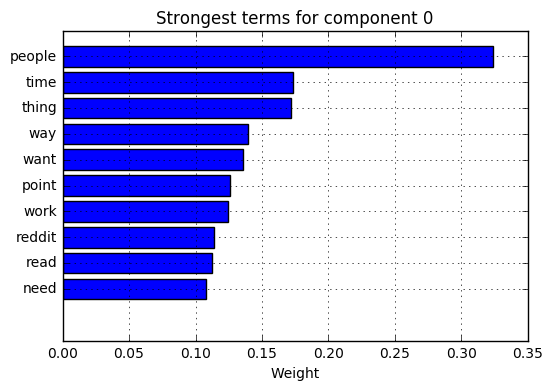

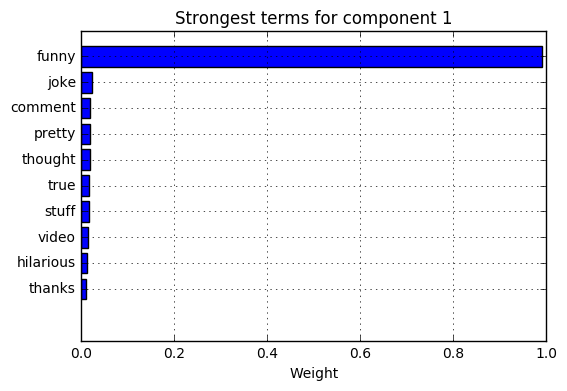

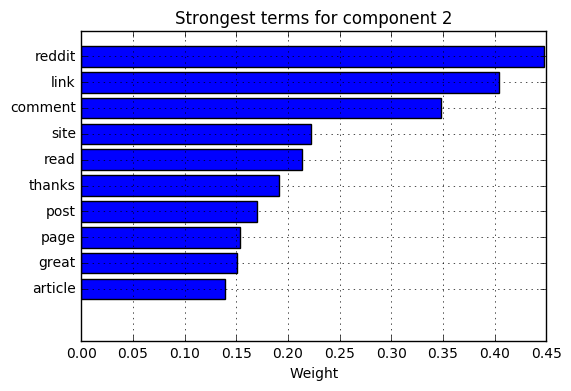

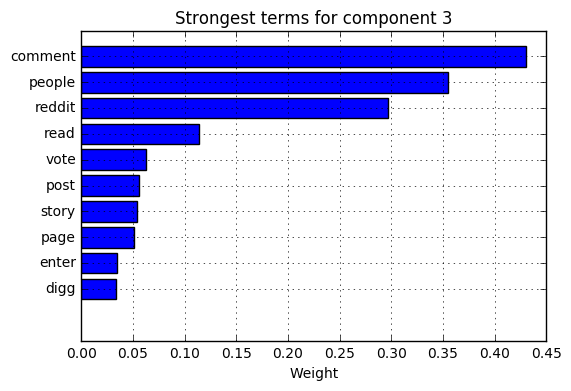

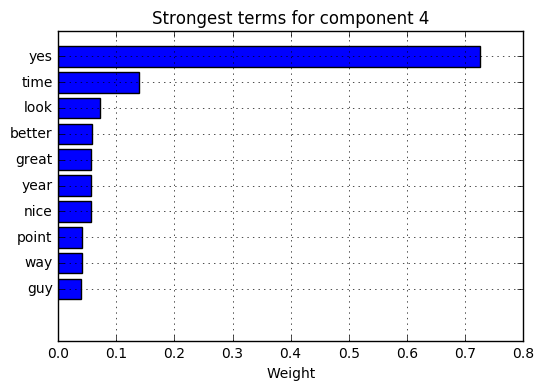

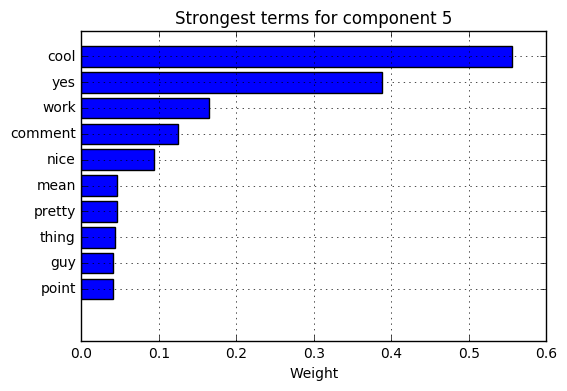

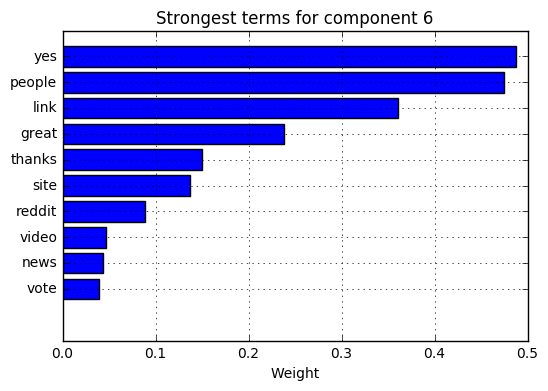

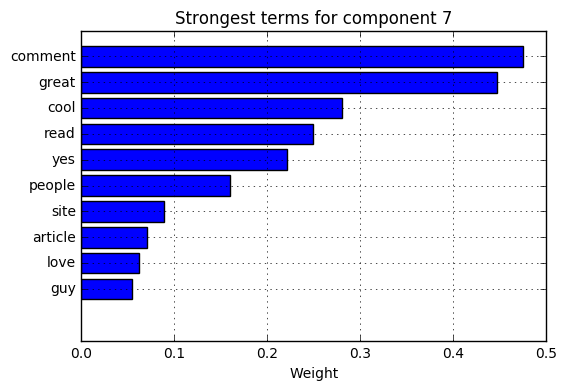

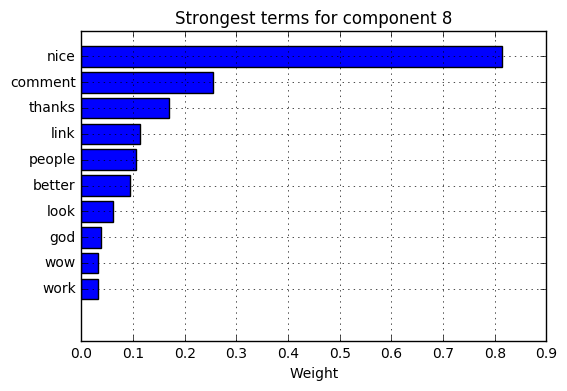

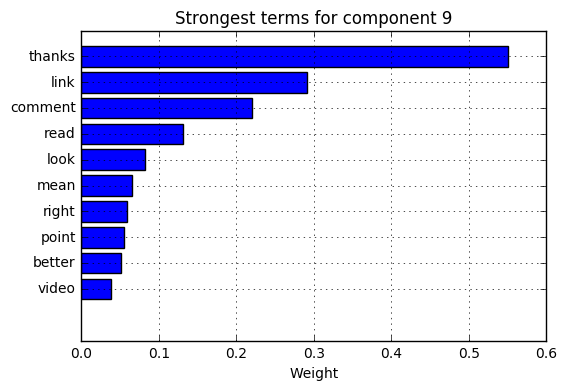

In [12]:
svd_test = TruncatedSVD(10)
lsa_test = make_pipeline(svd_test, preprocessing.Normalizer(copy=False))
feat_names = vectorizer.get_feature_names()

X_train_lsa = lsa_test.fit_transform(trans_vecs)

# The SVD matrix will have one row per component, and one column per feature
# of the original data.

for component_num in range(0, 10):

    comp = svd_test.components_[component_num]
    
    # Sort the weights in the first component, and get the indeces.
    indeces = np.argsort(comp).tolist()
    
    # Get largest weights first.
    indeces.reverse()
    
    # Get top 10 terms with highest weight in this component.        
    terms = [feat_names[weightIndex] for weightIndex in indeces[0:10]]    
    weights = [comp[weightIndex] for weightIndex in indeces[0:10]]    
   
    # Plot terms and weights as a horizontal bar graph.    
    # The horizontal bar graph displays the first item on the bottom; reverse
    # the order of the terms so the biggest one is on top.
    terms.reverse()
    weights.reverse()
    positions = range(10)    # the bar centers on the y axis
    
    plt.figure(component_num)
    plt.barh(positions, weights, align='center')
    plt.yticks(positions, terms)
    plt.xlabel('Weight')
    plt.title('Strongest terms for component %d' % (component_num))
    plt.grid(True)
    plt.show()

### LDA with gensim

In [15]:
lda = models.LdaModel(tfidf_corpus, id2word=id2word,
                        num_topics=30,
                        passes=1,
                        alpha = 0.01)

In [ ]:
#lda = models.LdaModel.load('LDA001_40-20-0001.lda')
#lda.save('LDA001_40-1-001.lda')
#lda.save('LDA002_30-5-001.lda')

In [82]:
user_data = pyLDAvis.gensim.prepare(lda, tfidf_corpus, id2word)
pyLDAvis.display(user_data)

#### Create a data frame with all 30 topics and label most of them.
Politics: 0  
Programming: 1, 13  
Information: 12  
negative: 3  
positive: 2  
Life / science: 6  
Election / voting: 10  
Gun legislation: 9, 11  
Work / Family: 15, 19   
Religion: 20  
Globalism: 21  
Internet: 22, 25  
Economy: 23  
War: 24  
Questions: 26  
Time / Past: 29  

In [149]:
topics_df = pd.DataFrame()
for i in range(30):
    topics_df[i] = lda.show_topics(30,50)[i][1].split('+')

In [273]:
topics_df.iloc[:10,1:10]

,1,2,3,4,5,6,7,8,9
0,"0.026*""software""","0.035*""look""","0.032*""stupid""","0.031*""car""","0.028*""meant""","0.023*""human""","0.037*""google""","0.023*""word""","0.020*""legal"""
1,"0.023*""programming""","0.026*""good""","0.017*""hate""","0.020*""drug""","0.025*""amp""","0.017*""science""","0.022*""worth""","0.023*""thanks""","0.019*""gun"""
2,"0.020*""ruby""","0.025*""great""","0.017*""line""","0.015*""drive""","0.016*""stick""","0.017*""theory""","0.016*""quality""","0.013*""class""","0.018*""paper"""
3,"0.015*""technology""","0.024*""idea""","0.015*""daily""","0.013*""people""","0.016*""info""","0.012*""argument""","0.013*""result""","0.012*""different""","0.015*""search"""
4,"0.014*""design""","0.021*""news""","0.012*""mistake""","0.012*""democracy""","0.015*""network""","0.012*""number""","0.012*""model""","0.011*""true""","0.015*""increase"""
5,"0.013*""feature""","0.018*""thing""","0.012*""worked""","0.011*""charge""","0.013*""moving""","0.011*""study""","0.012*""average""","0.011*""object""","0.014*""step"""
6,"0.012*""type""","0.018*""people""","0.012*""somebody""","0.011*""risk""","0.012*""impact""","0.010*""effect""","0.011*""math""","0.010*""english""","0.013*""worker"""
7,"0.011*""easier""","0.016*""know""","0.011*""skill""","0.011*""amazing""","0.012*""ton""","0.010*""earth""","0.010*""extra""","0.008*""performance""","0.013*""shot"""
8,"0.011*""conferencing""","0.015*""sound""","0.011*""people""","0.010*""debate""","0.011*""stated""","0.009*""life""","0.010*""expensive""","0.008*""church""","0.012*""period"""
9,"0.011*""wow""","0.014*""really""","0.009*""macro""","0.009*""idiot""","0.011*""channel""","0.009*""deleting""","0.008*""entry""","0.008*""evolution""","0.011*""early"""


Retrieve vectors for the original tfidf corpus in the LSI space ("transform" in sklearn).  
Dump the resulting document vectors into a list so we can take a look.

In [61]:
lda_corpus = lda[tfidf_corpus]
doc_vecs = [doc for doc in lda_corpus]

[(11, 0.77692307692307694)]

In [142]:
doc_vecs[:3]

[[(19, 0.87391304347826171)],
 [(2, 0.098528740333098552),
  (6, 0.068313097609924031),
  (7, 0.11563087216647423),
  (13, 0.34209548434429399),
  (14, 0.14370397704112453),
  (15, 0.077591563715102965),
  (21, 0.1391035850514197)],
 [(0, 0.16440579244085177),
  (2, 0.1658946992613094),
  (9, 0.090050786849786624),
  (13, 0.063635379008529003),
  (15, 0.11733382041912122),
  (16, 0.066468929133996713),
  (25, 0.31810016343855241)]]

Pick topic with highest proportion of all relevant topics for that comment.

In [151]:
import operator
list(zip(doc_vecs[:10],df_test['author']))
a = sorted(doc_vecs[1])+sorted(doc_vecs[2])+sorted(doc_vecs[3])

for i in range(10):
    print(max(sorted(doc_vecs[i]),key=operator.itemgetter(1))[0])


19
13
25
8
16
11
22
7
24
8


Create columns with assigned topics to each comment. 

In [229]:
topics_per_user = [str(max(doc_vecs[i],key=operator.itemgetter(1))[0]) for i in range(len(df_clean))]

In [234]:
df_clean['topics'] = topics_per_user

Create user dataframe with their topics.

In [235]:
df_clean.head()

,author,controversiality,score,text,topics
12966,--k,0.0,0.0,help influencing,19
323974,-Buzza-,1.0,2.0,maker must seen snake plane thought maybe appl...,13
286306,-Buzza-,0.0,1.0,seen longer version video appears two gent bea...,25
321994,-Buzza-,0.0,3.0,id also campw audience get bit bored hearing s...,8
399529,-Yh-,0.0,1.0,learn read sign buycom visa card buy drive 297...,16


In [236]:
# Concat topics for each user
df_clean['topics'] = df_clean.groupby(['author'])['topics'].transform(lambda x: ','.join(x))

In [237]:
users_df = df_clean.loc[:,['author','topics']].drop_duplicates()

In [289]:
users_df[users_df['author'] == '-Buzza-']['topics'].values[0].split(',')

['13', '25', '8']

In [290]:
users_df.to_csv('users_df.csv',index=False)

In [270]:
lda.show_topics(30,50)

[(0,
  '0.025*"people" + 0.024*"state" + 0.021*"government" + 0.011*"right" + 0.011*"country" + 0.010*"power" + 0.009*"law" + 0.009*"force" + 0.008*"freedom" + 0.008*"group" + 0.008*"death" + 0.008*"terrorist" + 0.007*"action" + 0.007*"society" + 0.007*"attack" + 0.007*"act" + 0.007*"crime" + 0.006*"world" + 0.006*"police" + 0.006*"citizen" + 0.006*"nation" + 0.006*"way" + 0.006*"american" + 0.005*"free" + 0.005*"moral" + 0.005*"life" + 0.005*"iran" + 0.005*"case" + 0.005*"problem" + 0.005*"fact" + 0.005*"fear" + 0.005*"united" + 0.005*"kill" + 0.005*"member" + 0.004*"threat" + 0.004*"killed" + 0.004*"want" + 0.004*"killing" + 0.004*"corporation" + 0.004*"thing" + 0.004*"congress" + 0.004*"speech" + 0.004*"demand" + 0.004*"court" + 0.004*"reason" + 0.004*"bomb" + 0.004*"public" + 0.004*"believe" + 0.004*"mean" + 0.004*"person"'),
 (1,
  '0.026*"software" + 0.023*"programming" + 0.020*"ruby" + 0.015*"technology" + 0.014*"design" + 0.013*"feature" + 0.012*"type" + 0.011*"easier" + 0.011*

In [124]:
topics_df.iloc[:2,19:31]

,19,20,21,22,23,24,25,26,27,28,29
0,"0.033*""people""","0.029*""god""","0.033*""woman""","0.044*""comment""","0.028*""free""","0.040*""war""","0.046*""read""","0.046*""question""","0.023*""return""","0.032*""language""","0.072*""year"""
1,"0.020*""work""","0.028*""believe""","0.030*""country""","0.039*""site""","0.022*""money""","0.037*""bush""","0.035*""article""","0.036*""test""","0.020*""city""","0.022*""code""","0.029*""old"""


### HDP Model

In [ ]:
hdp = models.hdpmodel(tfidf_corpus, id2word=id2word,
                        passes=1,
                        alpha = 0.01)

### NMF

In [43]:
from sklearn.decomposition import NMF
model = NMF(n_components=5, init='random', random_state=0)
doc_topics = model.fit_transform(trans_vecs)

In [44]:
doc_cluster = [list(r).index(max(r)) for r in doc_topics]

from collections import defaultdict
clusters = defaultdict(list)
for i in doc_cluster:
    clusters[i].append(i)
    
w = sorted([(i,v) for v,i in vectorizer.vocabulary_.items()])
topic_words = []
for r in model.components_:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:7]
    topic_words.append([w[e[1]] for e in a])


In [48]:
topic_words

[[(22734, 'people'),
  (12891, 'good'),
  (17165, 'know'),
  (18517, 'make'),
  (31286, 'thing'),
  (31475, 'time'),
  (25242, 'really')],
 [(25468, 'reddit'),
  (13109, 'great'),
  (28428, 'site'),
  (23653, 'post'),
  (20687, 'nice'),
  (29833, 'story'),
  (22218, 'page')],
 [(6375, 'cool'),
  (25242, 'really'),
  (24041, 'pretty'),
  (18126, 'look'),
  (31185, 'thanks'),
  (28428, 'site'),
  (33526, 'video')],
 [(12273, 'funny'),
  (16714, 'joke'),
  (24041, 'pretty'),
  (31341, 'thought'),
  (32086, 'true'),
  (25242, 'really'),
  (29993, 'stuff')],
 [(5601, 'comment'),
  (17895, 'link'),
  (25196, 'read'),
  (31185, 'thanks'),
  (1789, 'article'),
  (23653, 'post'),
  (22218, 'page')]]